Phil McCormick

ECON 630-02

November 12, 2022

Assignment 3

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
# Set a random seed
np.random.seed(4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ECON 630/data_assignment3.csv')

In [ ]:
df.head()

,revenue,treatment,compliance,age,gender,weekly,zone,signal
0,13.327541,1,0,65,m,2,e,4.037839
1,23.808945,1,0,37,m,7,b,4.050101
2,24.997824,1,0,51,m,1,d,3.966287
3,22.750393,1,0,59,o,3,c,4.091852
4,24.001336,1,0,38,o,0,b,4.091740


**Problem 1: Non-Compliance**

Suppose you are a data scientist at DoorDash, and you implement a new feature – linking of Venmo
accounts to pay for meals – to increase revenue. You run a large experiment to test its impact in
a given city, with an equal-sized treatment and control group. You want to understand the effect
of linking the account on revenue. Of course, you cannot force users to link their accounts, and so
that form of non-compliance will have to be handled.
The data following the experiment is in the file data assignment3.csv. The file has 10,000 rows.
Each row corresponds to a separate user, for which there are eight columns. Seven of the columns
are collected at the time of the experiment: revenue brought in by the user, an indicator for
whether the user is in the treatment group (where 1 indicates treatment), an indicator for whether
the user actually complied with the treatment (i.e. linked their Venmo account, where 1 indicates
compliance), the age of the user, the gender of the user (male, female, or other), the number of
days in the last week the user has been active on the app, and the geographic zone (coded as (a)
through (h)) of the user in the city. The last column (“signal”) should be put aside for now, and
will be incorporated into the question later.

1. (10 points) Estimate the treatment effect per the as-treated estimator, and then estimate
the treatment effect using the per-protocol estimator. (You do not need to construct standard
errors.) Explain in one sentence the assumption that both methodologies embed, and show
using the data that this assumption is likely invalid.

In [ ]:
#AS-TREATED
df1 = df.copy(deep=True)
df1['treatment'] = np.where((df1['treatment'] == 1) & (df1['compliance'] == 0), 0, df1['treatment'])

In [ ]:
rev_treat = df1.loc[df1["treatment"]==1,["revenue"]]
rev_control = df1.loc[df1["treatment"]==0,["revenue"]]

as_treat = rev_treat.mean() - rev_control.mean()
as_treat

revenue    7.249241
dtype: float64

In [ ]:
#Per Protocol
df2 = df.copy(deep=True)
df2 = df2.drop(df[(df["treatment"]==1) & (df["compliance"]==0)].index)

In [ ]:
rev_treat_1 = df2.loc[df2["treatment"]==1,["revenue"]]
rev_control_1 = df2.loc[df2["treatment"]==0,["revenue"]]

per_prot = rev_treat_1.mean() - rev_control_1.mean()
per_prot

revenue    7.197003
dtype: float64

Both of these methodologies do not address selection bias in the treatment group and hurt the power of the estimator by not properly accounting for the different weights of the experiment groups

2. (10 points) Estimate the treatment effect per the intent-to-treat estimator, and then es-
timate the treatment effect per the Wald estimator. (Again, you do not need to construct
standard errors.) In one sentence each, explain exactly what each number measures. Explain
in one further sentence why these estimates differ (substantially) from each other.

In [ ]:
#intent to treat

In [ ]:
rev_treat= df.loc[df["treatment"]== 1,["revenue"]]
rev_control= df.loc[df["treatment"]== 0,["revenue"]]

In [ ]:
itt = rev_treat.mean() - rev_control.mean()
itt

revenue    0.189844
dtype: float64

The intent to treat estimate simply calculates the treatment effect, but does not address compliance and therefore adds selection bias to the estimate.

In [ ]:
#WALD estimator
df2 = df.copy(deep=True)
df2 = df.loc[(df['treatment'] == 1) & (df['compliance'] == 1)]
avg_treat_comp = df2.revenue.mean()
WALD = itt / avg_treat_comp
WALD

revenue    0.007595
dtype: float64

The Wald estimator divides the intent to treat by the average treated compliance, to capture the effect of actually taking treatment in the experiment. Since it factors in compliance, the treatment effect is more accurate, but also less than in the intent to treat at .008 (down from .19 in intent to treat).

3. (10 points) Compute the standard deviation of the Wald estimate using the bootstrap with
at least 2,000 iterations. As always, explain and justify the choices you make in performing
the bootstrap.

In [ ]:
#WALD estimate

In [ ]:

# Compute difference in means
effect = (np.average(df.loc[df['treatment'] == 1,'revenue']) -
np.average(df.loc[df['treatment'] == 0,'revenue']))
# Compute bootstrapped estimates
# First identify the treated and control units
samples = []
i = np.where(df['treatment'] == 1)[0]
j = np.where(df['treatment'] == 0)[0]
# Set some fixed seed
np.random.seed(0)
# Run 2000 iterations of the bootstrap
for counter in range(2000):
# Implement re-sampling; notice we respect 5000 treated and 5000 control units
# at all times, to mimic the original experiment!
  i_sample = np.random.choice(i, len(i), replace = True)
  j_sample = np.random.choice(j, len(j), replace = True)
  # Create resampled data
  resample = df.iloc[np.append(i_sample, j_sample),]
  # Compute difference in means in resampled data 
  samples.append(
  np.average(resample.loc[resample['treatment'] == 1,'revenue']) - np.average(resample.loc[resample['treatment'] == 0,'revenue'])/(np.mean(resample.loc[(resample['treatment'] == 1) & (resample['compliance'] == 1), 'revenue'])))
print('The parameter estimate is ' + str(round(effect, 2)))
print('The bootstrapped SE is ' + str(round(np.std(samples), 2)))

The parameter estimate is 0.19
The bootstrapped SE is 0.09


4. Using the variables given (excluding “signal”), construct the estimate as given by the weighted
Wald estimator. There are three key steps:

(a) (10 points) First, predict compliance in the dataset using all pre-experimental variables
except signal. To predict compliance, use the treated group to fit a linear regression
model, as the treated group is the group who received the choice to comply or not.
Then, use that fitted model to predict compliance across the entire dataset, i.e. across
the treated and control groups alike. Note that full credit will be awarded to linear
regression models, but you are welcome to pick any more complicated class of models
(e.g. logistic regression, random forest, etc) if curious.


In [ ]:
df4 = df.copy(deep=True)

In [ ]:
df4 = df4.drop(df4[(df4["treatment"]==0)].index)
df4

,revenue,treatment,compliance,age,gender,weekly,zone,signal
0,13.327541,1,0,65,m,2,e,4.037839
1,23.808945,1,0,37,m,7,b,4.050101
2,24.997824,1,0,51,m,1,d,3.966287
3,22.750393,1,0,59,o,3,c,4.091852
4,24.001336,1,0,38,o,0,b,4.091740
...,...,...,...,...,...,...,...,...
4995,16.640247,1,0,20,o,4,g,4.021323
4996,16.038328,1,0,47,o,0,c,4.312622
4997,24.345769,1,0,39,m,1,b,4.052588
4998,25.504740,1,0,49,m,5,g,3.733963


In [ ]:
result = sm.ols(formula="compliance ~ age + gender + weekly + zone", 
                data = df4).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             compliance   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     100.8
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          5.89e-208
Time:                        19:41:53   Log-Likelihood:                 1520.8
No. Observations:                5000   AIC:                            -3018.
Df Residuals:                    4988   BIC:                            -2939.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1923      0.012     16.371      

In [ ]:
weights = result.predict(df)
weights


0      -0.048051
1       0.013738
2      -0.009738
3       0.181052
4       0.006170
          ...   
9995   -0.056389
9996   -0.007406
9997    0.019695
9998    0.109610
9999    0.032011
Length: 10000, dtype: float64

In [ ]:
weights = np.array(weights)

In [ ]:
df['weights'] = np.array(weights)

In [ ]:
df['weight_rev'] = df.weights * df.revenue
df

,revenue,treatment,compliance,age,gender,weekly,zone,signal,weights,weight_rev
0,13.327541,1,0,65,m,2,e,4.037839,-0.048051,-0.640403
1,23.808945,1,0,37,m,7,b,4.050101,0.013738,0.327077
2,24.997824,1,0,51,m,1,d,3.966287,-0.009738,-0.243428
3,22.750393,1,0,59,o,3,c,4.091852,0.181052,4.119009
4,24.001336,1,0,38,o,0,b,4.091740,0.006170,0.148085
...,...,...,...,...,...,...,...,...,...,...
9995,19.930093,0,0,63,o,5,d,4.025142,-0.056389,-1.123839
9996,22.369214,0,0,48,m,3,h,4.212572,-0.007406,-0.165666
9997,25.611632,0,0,36,m,5,g,3.932084,0.019695,0.504415
9998,19.664749,0,0,36,m,4,a,4.212681,0.109610,2.155463


In [ ]:
df2=df.loc[(df['treatment'] == 1) & (df['compliance'] == 1)]
df2

,revenue,treatment,compliance,age,gender,weekly,zone,signal,weights,weight_rev
36,22.766160,1,1,27,f,5,c,4.825855,0.260251,5.924925
45,29.711148,1,1,36,f,1,c,5.044911,0.242888,7.216495
62,22.638085,1,1,21,m,6,c,5.150665,0.282984,6.406221
106,26.800444,1,1,48,f,0,c,5.297295,0.214866,5.758515
118,31.246848,1,1,18,m,2,a,5.063844,0.155578,4.861329
...,...,...,...,...,...,...,...,...,...,...
4766,16.563478,1,1,28,f,1,c,4.938427,0.262319,4.344920
4779,23.371625,1,1,30,m,5,c,5.028645,0.262249,6.129179
4825,27.681646,1,1,30,m,2,c,4.900100,0.265621,7.352834
4842,16.159265,1,1,18,f,3,c,5.120005,0.284359,4.595039


In [ ]:
treat_comp_weight_sum = df2.weights.sum()
treat_comp_weight_sum

43.670006312329576

(b) (5 points) Second, using these predictions as the weights, estimate the treatment effect as given by the weighted Wald estimator. Remember that the weighted Wald estimator is mathematically the same as the Wald estimator, except each term in the numerator and denominator is multiplied by that observation’s weight.

In [ ]:
treat_weights = df.loc[df["treatment"]==1,["weights"]]
treat_weight_sum = treat_weights.sum()
treat_weight_sum

weights    203.0
dtype: float64

In [ ]:
weighted_revenue_treat = df.loc[df["treatment"]==1,["weight_rev"]]
weighted_revenue_control = df.loc[df["treatment"]==0,["weight_rev"]]
weighted_treatment_compliance = (len(df2)/len(weighted_revenue_treat))

In [ ]:
treated_weights

,weights
2732,0.061823
2607,0.024648
1653,-0.006310
3264,0.050036
4931,-0.010937
...,...
4769,-0.041799
4092,-0.017600
2568,-0.011555
846,0.031418


In [ ]:
avg_treat_comply_weights = float(treated_comply_weight_sum/treat_weight_sum)
float(avg_treat_comply_weights)

0.2151231838045828

In [ ]:
weighted_difference = weighted_revenue_treat.mean() - weighted_revenue_control.mean()
weighted_difference

weight_rev    0.035908
dtype: float64

In [ ]:
weighted_wald_estimator_v2 = (weighted_revenue_treat.mean() - weighted_revenue_control.mean())/(avg_treat_comply_weights)
weighted_wald_estimator_v2

weight_rev    0.166916
dtype: float64

(c) (10 points) Third, compute the standard deviation of the weighted Wald estimator by bootstrapping, using at least 2,000 iterations. Note that you do not need to re-train a linear regression model on each iteration.

In [ ]:
# Compute bootstrapped estimates
# First identify the treated and control units
samples4 = []
i = np.where(df['treatment'] == 1)[0]
j = np.where(df['treatment'] == 0)[0]
# Set some fixed seed
np.random.seed(0)
# Run 2000 iterations of the bootstrap
for counter in range(2000):
  # Implement re-sampling with 5000 treated and 5000 control units
  i_sample = np.random.choice(i, len(i), replace = True)
  j_sample = np.random.choice(j, len(j), replace = True)
    # Create resampled data
  resample = df.iloc[np.append(i_sample, j_sample),]
    #subset resampled data to find number of people in treatment that complied
  df_r=resample.loc[(resample['treatment'] == 1) & (resample['compliance'] == 1)]
  treated_weights = resample.loc[df["treatment"]==1,["weights"]]
    #find proportion of people in treated group that complied 
  avg_treat_comply = float((df_r.weights.sum())/treated_weights.sum())
  a = np.average(resample.loc[resample['treatment'] == 1,'weight_rev'])
  b = np.average(resample.loc[resample['treatment'] == 0,'weight_rev'])
    # Compute difference in means in resampled data and divided by average treated compliance
  samples4.append((a-b)/avg_treat_comply)

In [ ]:
  print('The bootstrapped SE is ' + str(round(np.std(samples4), 4)))

The bootstrapped SE is 0.154


5. Now let’s introduce the last variable, signal. A data scientist at DoorDash tells you that she has found a high-quality predictor of compliance, called signal.

(a) (10 points) First, using this new variable along with all original variables: (i) build a new model to predict compliance, (ii) generate a new weighted Wald estimate, and (iii) generate new standard errors by bootstrap (using 2,000 iterations).


In [ ]:
result_2 = sm.ols(formula="compliance ~ age + gender + weekly + zone + signal", 
                data = df4).fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:             compliance   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     831.9
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:46:56   Log-Likelihood:                 3766.9
No. Observations:                5000   AIC:                            -7508.
Df Residuals:                    4987   BIC:                            -7423.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.2739      0.030    -76.052      

In [ ]:
new_weights = result_2.predict(df)
new_weights

0      -0.002425
1       0.034927
2      -0.020371
3       0.125139
4       0.053824
          ...   
9995   -0.003912
9996    0.122873
9997   -0.029820
9998    0.173712
9999   -0.018019
Length: 10000, dtype: float64

In [ ]:
new_weights = np.array(new_weights)
new_weights

array([-0.00242484,  0.03492654, -0.02037136, ..., -0.0298205 ,
        0.17371164, -0.01801875])

In [ ]:
df['new_weights'] = new_weights

In [ ]:
df['new_signal_revenue'] = np.multiply(new_weights, df.revenue)
df

,revenue,treatment,compliance,age,gender,weekly,zone,signal,weights,weight_rev,new_weights,new_signal_revenue
0,13.327541,1,0,65,m,2,e,4.037839,-0.048051,-0.640403,-0.002425,-0.032317
1,23.808945,1,0,37,m,7,b,4.050101,0.013738,0.327077,0.034927,0.831564
2,24.997824,1,0,51,m,1,d,3.966287,-0.009738,-0.243428,-0.020371,-0.509240
3,22.750393,1,0,59,o,3,c,4.091852,0.181052,4.119009,0.125139,2.846965
4,24.001336,1,0,38,o,0,b,4.091740,0.006170,0.148085,0.053824,1.291846
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19.930093,0,0,63,o,5,d,4.025142,-0.056389,-1.123839,-0.003912,-0.077968
9996,22.369214,0,0,48,m,3,h,4.212572,-0.007406,-0.165666,0.122873,2.748580
9997,25.611632,0,0,36,m,5,g,3.932084,0.019695,0.504415,-0.029820,-0.763752
9998,19.664749,0,0,36,m,4,a,4.212681,0.109610,2.155463,0.173712,3.415996


In [ ]:
df3=df.loc[(df['treatment'] == 1) & (df['compliance'] == 1)]
df3

,revenue,treatment,compliance,age,gender,weekly,zone,signal,weights,weight_rev,new_weights,new_signal_revenue
36,22.766160,1,1,27,f,5,c,4.825855,0.260251,5.924925,0.585536,13.330406
45,29.711148,1,1,36,f,1,c,5.044911,0.242888,7.216495,0.704903,20.943484
62,22.638085,1,1,21,m,6,c,5.150665,0.282984,6.406221,0.793097,17.954203
106,26.800444,1,1,48,f,0,c,5.297295,0.214866,5.758515,0.840437,22.524073
118,31.246848,1,1,18,m,2,a,5.063844,0.155578,4.861329,0.693495,21.669518
...,...,...,...,...,...,...,...,...,...,...,...,...
4766,16.563478,1,1,28,f,1,c,4.938427,0.262319,4.344920,0.650903,10.781219
4779,23.371625,1,1,30,m,5,c,5.028645,0.262249,6.129179,0.711776,16.635362
4825,27.681646,1,1,30,m,2,c,4.900100,0.265621,7.352834,0.636419,17.617136
4842,16.159265,1,1,18,f,3,c,5.120005,0.284359,4.595039,0.768239,12.414171


In [ ]:
df3.new_weights.sum()

138.1182419160276

In [ ]:
signal_weighted_revenue_treat = df.loc[df["treatment"]==1,["new_signal_revenue"]]
signal_weighted_revenue_control = df.loc[df["treatment"]==0,["new_signal_revenue"]]

In [ ]:
signal_treated_weights = df.loc[df["treatment"]==1,["new_weights"]]
signal_treated_weight_sum = signal_treated_weights.sum()
signal_treated_weight_sum

new_weights    203.0
dtype: float64

In [ ]:
signal_treated_comply_weight_sum = df3.new_weights.sum()
signal_treated_comply_weight_sum

138.1182419160276

In [ ]:
avg_signal_treat_comply_weights = float(signal_treated_comply_weight_sum/signal_treated_weight_sum)
float(avg_signal_treat_comply_weights)

0.6803854281577733

In [ ]:
signal_weighted_wald_estimator = (signal_weighted_revenue_treat.mean() - signal_weighted_revenue_control.mean())/(avg_signal_treat_comply_weights)
signal_weighted_wald_estimator

new_signal_revenue    0.229376
dtype: float64

In [ ]:
# Compute difference in means

# Compute bootstrapped estimates
# First identify the treated and control units
samples5 = []
i = np.where(df['treatment'] == 1)[0]
j = np.where(df['treatment'] == 0)[0]
# Set some fixed seed
np.random.seed(0)
# Run 2000 iterations of the bootstrap
for counter in range(2000):
  # Implement re-sampling with 5000 treated and 5000 control units
  i_sample = np.random.choice(i, len(i), replace = True)
  j_sample = np.random.choice(j, len(j), replace = True)
    # Create resampled data
  resample = df.iloc[np.append(i_sample, j_sample),]
    #subset resampled data to find number of people in treatment that complied
  df_r=resample.loc[(resample['treatment'] == 1) & (resample['compliance'] == 1)]
  treated_weights = resample.loc[df["treatment"]==1,["new_weights"]]
  #treated_weight_sum = treated_weights.sum()
    #find proportion of people in treated group that complied 
  avg_treat_comply = float((df_r.new_weights.sum())/treated_weights.sum())
  a = np.average(resample.loc[resample['treatment'] == 1,'new_signal_revenue'])
  b = np.average(resample.loc[resample['treatment'] == 0,'new_signal_revenue'])
    # Compute difference in means in resampled data and divided by average treated compliance
  samples5.append((a-b)/avg_treat_comply)

In [ ]:
print('The bootstrapped SE is ' + str(round(np.std(samples5), 2)))

The bootstrapped SE is 0.1


(b) (5 points) Second, compare the original weighted Wald estimator (i.e. without “signal”) against the enhanced weighted Wald estimator (i.e. with “signal”) on two metrics: performance of the compliance models (e.g. R2) and standard errors. In one or two sentences: which approach has a lower standard error, and why?

The weighted Wald estimator without "signal" variable included has a lower R^2 (.18 < .67) and a higher standard error (.152 > .1) than the weighted Wald estimator with "signal". The approach with the "signal" variabile included has a lower standard error because adding more variables decreases the variance and increases the R^2, though this does not necessarily make the estimator more accurate.

6. (5 points) We now have collected three estimates with three sets of standard errors: Wald,
weighted Wald for a simple model (i.e. no “signal”), and weighted Wald for an enhanced
model (i.e. with “signal”). Depict the standard errors of all three graphically, by plotting
their bootstrapped samples.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


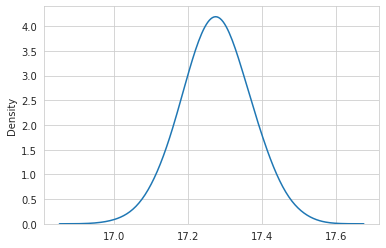

In [ ]:
#Wald estimate
sns.kdeplot(np.array(samples), bw=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


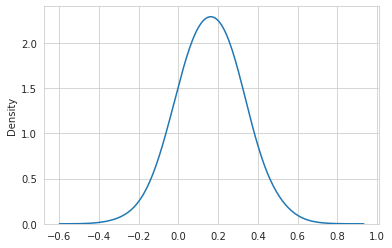

In [ ]:
#weighted Wald estimate
sns.kdeplot(np.array(samples4), bw=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


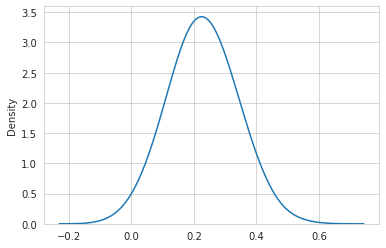

In [ ]:
#reweighted Wald estimate
sns.kdeplot(np.array(samples5), bw=0.5)

**Problem 2: Surrogates**

*Consider the following scenario: Airbnb wants to understand the effect of boosting host earnings in the US for October 1 (for instance, by giving the service fees it collects to hosts) on the number of bookings that a host accepts over the month of October. Unable to wait until the end of October to assess the one-day experiment, Airbnb considers utilizing the surrogacy methodology.*

*Now consider five variants of this experiment. For each variant, which one of the key assumptions is most likely violated, and why? Limit your answer to one to two sentences per answer.*

 

*1. (5 points) Airbnb uses the number of bookings that a host accepts on October 1 as the surrogate variable.*

This variant violates the surrogacy assumption. There may be other metrics that effect number of bookings not included in surrogacy, such as region and number of listings.

 
*2. (5 points) Airbnb uses the same surrogate variable, but changes the treatment to run from October 1 through October 3.*

This variant violates the surrogacy assumption. The experiment will run longer than your observational sample.

 

*3. (5 points) Airbnb uses two surrogate variables: the number of bookings that a host accepts from October 1 through October 3, and the number of properties that a host lists from October 1 through October 3. As in the original setup, the treatment is deployed on October
1 only.*

This variant violates the comparability assumption. The experiment only runs for a single day, while it is being compared to multiple day surrogacy.

 
*4. (5 points) Airbnb uses a long-running observational study from Japan to link its chosen surrogates to the downstream outcome.*

This variant violates the comparability assumption. These are two different markets (Japan and the US) so we cannot compare outcomes.

 

*5. (5 points) Airbnb uses observational data from the month of August (which is already available and without lags) to identify the treatment effect.*

This variant violates comparability assumption. The observational sample is from a different time than the experiment and therefore the link between surrogacy and the outcome is broken